In [44]:
import cv2 as cv
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.metrics import auc

A partir de la base de datos proporcionada, se realizará un programa que permita identificar las huellas del mismo usuario y descartar el resto, dando información cuantitativa de la similitud entre las huellas, pudiendo utilizar openCV, numpy, os, PyTorch,..., pero no funciones descargadas especialmente para trabajar con huellas dactilares.

Se obtendrá la función densidad de probabilidad, la curva DET, la curva ROC., el valor EER y el valor AUC.

Se realizará un póster (una única transparencia) y se presentará durante la última semana de clase. Además, se entregará el código usado.

En la presentación tienen que tratarse los siguientes puntos:

-Hipótesis de partida.

-Metodología utilizada y explicación de su desarrollo.

-Resultados (curvas, EER y AUC).

-Conclusiones.

-Fuentes principales consultadas.

## 1. Limpieza del dataset

### 1.2. Extraer la huella de la imagen

In [3]:
from clean_dataset.hand_cleaning import build_dataset
from clean_dataset.scikit_cleaning  import build_dataset_frangi

In [4]:
sample_path = r"\BaseDatosNISTsd09_pr"
output_hand_dataset = "./datasets/hand_dataset"
output_frangi_dataset = "./datasets/frangi_dataset"
sample_path = os.getcwd()+sample_path
subfolders= os.listdir(sample_path)

build_dataset_frangi(sample_path, subfolders, output_frangi_dataset)
build_dataset(sample_path, subfolders, output_hand_dataset)

## 2. Planteamiento del sistema

In [7]:
sample_path = r"\BaseDatosNISTsd09_pr"
output_hand_dataset = "./datasets/hand_dataset"
output_frangi_dataset = "./datasets/frangi_dataset"
sample_path = os.getcwd()+sample_path
subfolders= os.listdir(sample_path)

In [8]:
targets = {}
i = 0

for folder in subfolders:
    for file in os.listdir(sample_path + "/" + folder):
        targets[file] = 1
    if i == 6:
        break
    i += 1

i = 0
for folder in subfolders:
    if i > 6:
        for file in os.listdir(sample_path + "/" + folder):
            targets[file] = 0
    i += 1

print(targets)

{'crd_0811f_01.png': 1, 'crd_0811s_01.png': 1, 'crd_0812f_01.png': 1, 'crd_0812s_01.png': 1, 'crd_0813f_01.png': 1, 'crd_0813s_01.png': 1, 'crd_0814f_01.png': 1, 'crd_0814s_01.png': 1, 'crd_0815f_01.png': 1, 'crd_0815s_01.png': 1, 'crd_0816f_01.png': 1, 'crd_0816s_01.png': 1, 'crd_0817f_01.png': 1, 'crd_0817s_01.png': 1, 'crd_0818f_01.png': 0, 'crd_0818s_01.png': 0, 'crd_0819f_01.png': 0, 'crd_0819s_01.png': 0, 'crd_0820f_01.png': 0, 'crd_0820s_01.png': 0}


### 2.1. SIFT (Scale-Invariant Feature Transform)

In [9]:
dataset_path = output_frangi_dataset
users = {}
i = 0

for subfolder in subfolders:
    path = os.listdir(dataset_path + '\\' + subfolder)
    route = dataset_path + '\\' + subfolder + '\\' + path[0]

    img = cv.imread(route)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    sift = cv.SIFT_create()
    kp, des = sift.detectAndCompute(gray, None)
    users[path[0]] = (kp, des, path[0])
    if i == 6:
        break
    i += 1


In [10]:
for subfolder in subfolders:
    path = os.listdir(dataset_path + '\\' + subfolder)
    route = dataset_path + '\\' + subfolder + '\\' + path[0]
    os.remove(route)

In [11]:
def find_match(new_kp, new_des, users, threshold=230):
    bf = cv.BFMatcher(cv.NORM_L2, crossCheck=True)
    for user_id, (kp, des, img) in users.items(): 
        matches = bf.match(new_des, des)
        sorted_matches = sorted(matches, key=lambda x: x.distance)

        if sorted_matches and sorted_matches[0].distance < threshold:
            return True, img

    return False, None 

#### 1. Curva DET y EER

In [38]:
correct = 0
true_positive = 0
true_negative = 0
total = 0
thresholds = np.linspace(0, 500, 300)

false_accepted = []
false_rejected = []
int_usuario_no = 6
int_usuarios_si = 7

dataset_path

for threshold in thresholds:
    number_false_rejected = 0
    number_false_accepted = 0
    for subfolder in subfolders:
        for file in os.listdir(dataset_path + '\\' + subfolder):
            path = dataset_path + '\\' + subfolder + '\\' + file
            true_target = targets[file]
            img = cv.imread(path)
            gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

            sift = cv.SIFT_create()
            kp, des = sift.detectAndCompute(gray, None)
            sift = cv.SIFT_create()
            new_kp, new_des = sift.detectAndCompute(gray, None)

            result, img_name = find_match(new_kp, new_des, users, threshold)
            if int(result) == 0 and true_target == 1:
                number_false_rejected += 1
            
            elif int(result) == 1 and true_target == 0:
                number_false_accepted += 1
            
            elif int(result) == true_target:
                correct += 1
            total += 1
    far = number_false_accepted / int_usuario_no
    frr = number_false_rejected / int_usuarios_si

    false_accepted.append(far)
    false_rejected.append(frr)

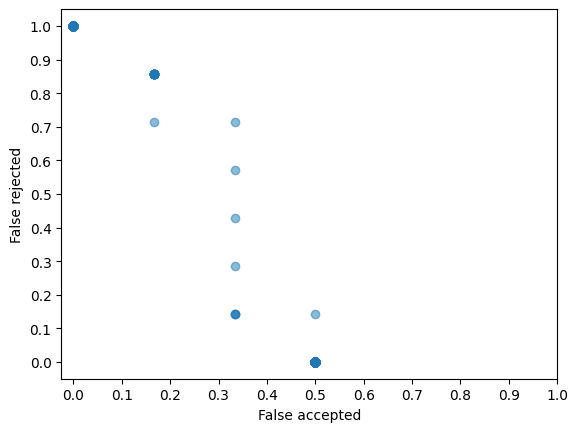

In [39]:
plt.plot(false_accepted, false_rejected, 'o', alpha=0.5)
plt.xlabel("False accepted")
plt.ylabel("False rejected")
plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.show()

In [40]:
print("Correct: ", correct)
print("Total: ", total)
print("True positive: ", true_positive)
print("True negative: ", true_negative)
print("Accuracy: ", correct / total * 100, "%")

Correct:  1542
Total:  3000
True positive:  0
True negative:  0
Accuracy:  51.4 %


sift da un 40% de mierd

#### 2. Densidad de probabilidad

#### 3. Curva ROC y AUC

In [41]:
true_positive_rates = []
false_positive_rates = []
thresholds = np.linspace(0, 500, 300)

for threshold in thresholds:
    number_false_rejected = 0
    number_false_accepted = 0
    true_positive = 0
    true_negative = 0
    total_positive = 0
    total_negative = 0

    for subfolder in subfolders:
        for file in os.listdir(dataset_path + '\\' + subfolder):
            path = dataset_path + '\\' + subfolder + '\\' + file
            true_target = targets[file]
            img = cv.imread(path)
            gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

            sift = cv.SIFT_create()
            new_kp, new_des = sift.detectAndCompute(gray, None)

            result, img_name = find_match(new_kp, new_des, users, threshold)

            if true_target == 1:
                total_positive += 1
                if int(result) == 1:
                    true_positive += 1
                else:
                    number_false_rejected += 1
            else:
                total_negative += 1
                if int(result) == 0:
                    true_negative += 1
                else:
                    number_false_accepted += 1

    tpr = true_positive / total_positive if total_positive else 0
    fpr = number_false_accepted / total_negative if total_negative else 0

    true_positive_rates.append(tpr)
    false_positive_rates.append(fpr)

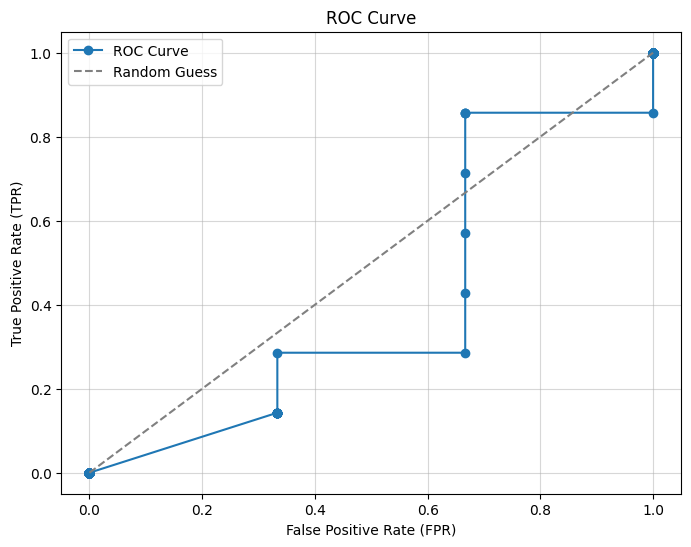

In [42]:
plt.figure(figsize=(8, 6))
plt.plot(false_positive_rates, true_positive_rates, marker='o', label='ROC Curve')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve")
plt.legend()
plt.grid(alpha=0.5)
plt.show()

In [45]:
roc_auc = auc(false_positive_rates, true_positive_rates)
print(f"Área bajo la curva (AUC): {roc_auc}")

Área bajo la curva (AUC): 0.40476190476190477


### 2.2. ResNet pre-entrenada

In [102]:
import cv2 as cv
import torchvision.models as models
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
import numpy as np
import os
from scipy.spatial.distance import cosine, euclidean

In [122]:
def extract_features(img_path, model):
    model.eval()
    image = cv.imread(img_path)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

    preprocess = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = preprocess(image).unsqueeze(0)

    with torch.no_grad():
        features = model(image).squeeze().numpy()
    return features

def compare_fingerprints(users, v2, threshold=0.1):
    for idx, user in enumerate(users):
        user = user.flatten() if user.ndim > 1 else user
        v2 = v2.flatten() if v2.ndim > 1 else v2
        
        distance = cosine(user, v2)
        if distance < threshold:
            return True
    return False

In [123]:
model = models.resnet50(pretrained=True)
model = nn.Sequential(*list(model.children())[:-1])

c:\Users\Susana\anaconda3\envs\piav\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Susana\anaconda3\envs\piav\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [120]:
users = []
sample_path = r"\BaseDatosNISTsd09_pr"
dataset_path = "./datasets/hand_dataset"
sample_path = os.getcwd() + sample_path
subfolders = os.listdir(sample_path)

for i, subfolder in enumerate(subfolders[:6]):
    path = os.listdir(dataset_path + '\\' + subfolder)
    route = dataset_path + '\\' + subfolder + '\\' + path[0]
    vector = extract_features(route, model)
    users.append(vector)

In [126]:
correct = 0
true_positive = 0
true_negative = 0
total = 0

thresholds = np.linspace(0, 1, 100)
false_accepted = []
false_rejected = []
int_usuario_no = 6
int_usuarios_si = 7

distances = []
labels = []

for threshold in thresholds:
    number_false_rejected = 0
    number_false_accepted = 0

    for subfolder in subfolders:
        path = os.listdir(dataset_path + '\\' + subfolder)
        
        for file_name in path:
            route = dataset_path + '\\' + subfolder + '\\' + file_name
            true_target = targets[file_name]
            v2 = extract_features(route, model)
            
            result = compare_fingerprints(users, v2, threshold)
            
            #print(f"{true_target} == {int(result)}")

            if int(result) == 0 and true_target == 1:
                number_false_rejected += 1
            
            elif int(result) == 1 and true_target == 0:
                number_false_accepted += 1
            
            elif int(result) == true_target:
                correct += 1
            total += 1
    far = number_false_accepted / int_usuario_no
    frr = number_false_rejected / int_usuarios_si

    false_accepted.append(far)
    false_rejected.append(frr)

    """print("Correct: ", correct)
    print("Total: ", total)
    print("Accuracy: ", correct / total * 100, "%")"""

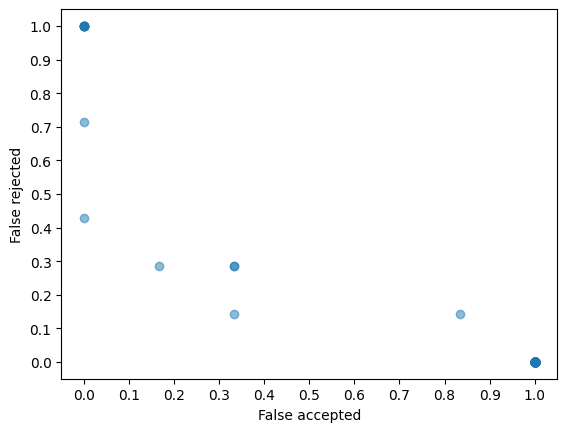

In [ ]:
plt.plot(false_accepted, false_rejected, 'o', alpha=0.5)
plt.xlabel("False accepted")
plt.ylabel("False rejected")
plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.show()

el error rate es 0.3

### 2.3 Red Convolutiva desde cero

#### Identificación   

In [3]:
import os
import cv2 as cv

def generate_rotated_img(img, angle, base_name, extension, root):
    (h, w) = img.shape[:2]
    center = (w // 2, h // 2)
    M = cv.getRotationMatrix2D(center, angle, 1.0)
    rotated_img = cv.warpAffine(img, M, (w, h))
    rotated_image_path = os.path.join(root, f"{base_name}_{angle}_grades{extension}")
    cv.imwrite(rotated_image_path, rotated_img)

def rotate_images_in_directory(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('png', 'jpg', 'jpeg', 'bmp', 'gif')):
                image_path = os.path.join(root, file)
                img = cv.imread(image_path)
                base_name = os.path.splitext(file)[0]
                extension = os.path.splitext(file)[1]
                for angle in range(1, 181):
                    generate_rotated_img(img, angle, base_name, extension, root)

In [5]:
directory = './datasets/conv_authentication'
rotate_images_in_directory(directory)

In [35]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torchvision import transforms

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation(10),  # Rotación aleatoria
    transforms.RandomHorizontalFlip(),  # Volteo horizontal
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = ImageFolder("./datasets/conv_identification", transform=transform)

train_size = int(0.7 * len(dataset))
test_size = int(0.2 * len(dataset)) 
eval_size = int(0.1 * len(dataset))
train_dataset, test_dataset, eval_dataset = random_split(dataset, [train_size, test_size, eval_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
eval_loader = DataLoader(eval_dataset, batch_size=32, shuffle=False)

In [36]:
import torch.nn as nn
import torch.nn.functional as F

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2)  # Entrada: 1 canal, Salida: 16 canales, kernel de 5x5
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # Max pooling con un kernel de 2x2
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2)  # Entrada: 16 canales, Salida: 32 canales
        self.fc1 = nn.Linear(32 * 7 * 7, 120)  # Imágenes reducidas a 7x7 después del pooling
        self.fc2 = nn.Linear(120, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [37]:
import torch
import torch.optim as optim

model = ConvNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")

correct = 0
total = 0
true_positive = 0
true_negative = 0

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        # Total de ejemplos
        total += labels.size(0)

        # Ejemplos correctamente clasificados
        correct += (predicted == labels).sum().item()

        # True Positive y True Negative
        true_positive += ((predicted == 1) & (labels == 1)).sum().item()
        true_negative += ((predicted == 0) & (labels == 0)).sum().item()

# Calcular métricas
accuracy = 100 * correct / total
print(f"Accuracy: {accuracy}%")
print(f"True Positive: {true_positive}")
print(f"True Negative: {true_negative}")


Epoch 1/10, Loss: 1.8622773960232735
Epoch 2/10, Loss: 1.1953670419752598
Epoch 3/10, Loss: 0.7755447011440992
Epoch 4/10, Loss: 0.5418874338269234
Epoch 5/10, Loss: 0.4120087897405028
Epoch 6/10, Loss: 0.29728019796311855
Epoch 7/10, Loss: 0.23995397193357348
Epoch 8/10, Loss: 0.21182678677141667
Epoch 9/10, Loss: 0.1840225917287171
Epoch 10/10, Loss: 0.17331103505566717
Accuracy: 99.72375690607734%
True Positive: 58
True Negative: 80


In [38]:
correct = 0
total = 0
true_positive = 0
true_negative = 0

model.eval()
with torch.no_grad():
    for inputs, labels in eval_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        # Total de ejemplos
        total += labels.size(0)

        # Ejemplos correctamente clasificados
        correct += (predicted == labels).sum().item()

        # True Positive y True Negative
        true_positive += ((predicted == 1) & (labels == 1)).sum().item()
        true_negative += ((predicted == 0) & (labels == 0)).sum().item()

        # False Positive y False Negative
        false_positive = ((predicted == 1) & (labels == 0)).sum().item()
        false_negative = ((predicted == 0) & (labels == 1)).sum().item()


# Calcular métricas
accuracy = 100 * correct / total
print(f"Accuracy: {accuracy}%")
print(f"True Positive: {true_positive}")
print(f"True Negative: {true_negative}")
print(f"False Positive: {false_positive}")
print(f"False Negative: {false_negative}")

Accuracy: 99.72375690607734%
True Positive: 41
True Negative: 27
False Positive: 0
False Negative: 0


In [54]:
dataset = ImageFolder("./datasets/hand_dataset", transform=transform)

train_size = int(0 * len(dataset))
test_size = int(0 * len(dataset)) 
eval_size = int(1 * len(dataset))
train_dataset, test_dataset, eval_dataset = random_split(dataset, [train_size, test_size, eval_size])

eval_loader = DataLoader(eval_dataset, batch_size=1, shuffle=False)

correct = 0
total = 0
true_positive = 0
true_negative = 0

model.eval()
with torch.no_grad():
    for inputs, labels in eval_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        # Total de ejemplos
        total += labels.size(0)

        # Ejemplos correctamente clasificados
        correct += (predicted == labels).sum().item()
        print(f'Model output: {predicted} <-> True label: {labels}')

# Calcular métricas
accuracy = 100 * correct / total
print(f"Accuracy: {accuracy}%")

Model output: tensor([9]) <-> True label: tensor([9])
Model output: tensor([7]) <-> True label: tensor([7])
Model output: tensor([1]) <-> True label: tensor([1])
Model output: tensor([1]) <-> True label: tensor([1])
Model output: tensor([6]) <-> True label: tensor([6])
Model output: tensor([8]) <-> True label: tensor([8])
Model output: tensor([4]) <-> True label: tensor([4])
Model output: tensor([3]) <-> True label: tensor([3])
Model output: tensor([7]) <-> True label: tensor([7])
Model output: tensor([8]) <-> True label: tensor([8])
Model output: tensor([5]) <-> True label: tensor([5])
Model output: tensor([5]) <-> True label: tensor([5])
Model output: tensor([9]) <-> True label: tensor([9])
Model output: tensor([0]) <-> True label: tensor([0])
Model output: tensor([0]) <-> True label: tensor([0])
Model output: tensor([4]) <-> True label: tensor([4])
Model output: tensor([6]) <-> True label: tensor([6])
Model output: tensor([3]) <-> True label: tensor([3])
Model output: tensor([2]) <-

#### Identificación y autentificación

In [56]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torchvision import transforms

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation(10),  # Rotación aleatoria
    transforms.RandomHorizontalFlip(),  # Volteo horizontal
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = ImageFolder("./datasets/conv_ide_auten", transform=transform)

train_size = int(0.7 * len(dataset))
test_size = int(0.2 * len(dataset)) 
eval_size = int(0.1 * len(dataset))
train_dataset, test_dataset, eval_dataset = random_split(dataset, [train_size, test_size, eval_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
eval_loader = DataLoader(eval_dataset, batch_size=32, shuffle=False)

In [57]:
import torch.nn as nn
import torch.nn.functional as F

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2)  # Entrada: 1 canal, Salida: 16 canales, kernel de 5x5
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # Max pooling con un kernel de 2x2
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2)  # Entrada: 16 canales, Salida: 32 canales
        self.fc1 = nn.Linear(32 * 7 * 7, 120)  # Imágenes reducidas a 7x7 después del pooling
        self.fc2 = nn.Linear(120, 8)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [58]:
import torch
import torch.optim as optim

model = ConvNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")

correct = 0
total = 0
true_positive = 0
true_negative = 0

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        # Total de ejemplos
        total += labels.size(0)

        # Ejemplos correctamente clasificados
        correct += (predicted == labels).sum().item()

# Calcular métricas
accuracy = 100 * correct / total
print(f"Accuracy: {accuracy}%")


Epoch 1/10, Loss: 1.781134980916977
Epoch 2/10, Loss: 1.39108572229743
Epoch 3/10, Loss: 0.962238322943449
Epoch 4/10, Loss: 0.6541771311312914
Epoch 5/10, Loss: 0.4399736037477851
Epoch 6/10, Loss: 0.3288029173389077
Epoch 7/10, Loss: 0.2615934966597706
Epoch 8/10, Loss: 0.18892331076785923
Epoch 9/10, Loss: 0.17939589247107507
Epoch 10/10, Loss: 0.1605178897967562
Accuracy: 99.30939226519337%


In [70]:
dataset = ImageFolder("./datasets/dataset_culero", transform=transform)

train_size = int(0 * len(dataset))
test_size = int(0 * len(dataset)) 
eval_size = int(1 * len(dataset))
train_dataset, test_dataset, eval_dataset = random_split(dataset, [train_size, test_size, eval_size])

eval_loader = DataLoader(eval_dataset, batch_size=1, shuffle=False)

correct = 0
total = 0
true_positive = 0
true_negative = 0

model.eval()
with torch.no_grad():
    for inputs, labels in eval_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        # Total de ejemplos
        total += labels.size(0)

        # Ejemplos correctamente clasificados
        correct += (predicted == labels).sum().item()
        print(f'Model output: {predicted} <-> True label: {labels}')

# Calcular métricas
accuracy = 100 * correct / total
print(f"Accuracy: {accuracy}%")

Model output: tensor([2]) <-> True label: tensor([6])
Model output: tensor([2]) <-> True label: tensor([7])
Model output: tensor([2]) <-> True label: tensor([7])
Model output: tensor([2]) <-> True label: tensor([7])
Model output: tensor([2]) <-> True label: tensor([2])
Model output: tensor([5]) <-> True label: tensor([5])
Model output: tensor([2]) <-> True label: tensor([0])
Model output: tensor([2]) <-> True label: tensor([6])
Model output: tensor([2]) <-> True label: tensor([2])
Model output: tensor([2]) <-> True label: tensor([4])
Model output: tensor([2]) <-> True label: tensor([5])
Model output: tensor([2]) <-> True label: tensor([0])
Model output: tensor([7]) <-> True label: tensor([4])
Model output: tensor([2]) <-> True label: tensor([7])
Model output: tensor([5]) <-> True label: tensor([7])
Model output: tensor([2]) <-> True label: tensor([1])
Model output: tensor([3]) <-> True label: tensor([3])
Model output: tensor([3]) <-> True label: tensor([3])
Model output: tensor([2]) <-

#### 2.3.1 Convolutiva con k-folds

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import KFold
from torchvision import datasets, transforms

In [ ]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation(10),  # Rotación aleatoria
    transforms.RandomHorizontalFlip(),  # Volteo horizontal
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.ImageFolder(root='./datasets/conv_identification', transform=transform)
num_classes = len(dataset.classes)

In [40]:
class ConvNet(nn.Module):
    def __init__(self, num_classes):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2)
        self.fc1 = nn.Linear(32 * 7 * 7, 120)
        self.fc2 = nn.Linear(120, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 32 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:
num_epochs = 10
k_folds = 5
batch_size = 32
learning_rate = 0.001

kfold = KFold(n_splits=k_folds, shuffle=True)

results = {}

for fold, (train_idx, test_idx) in enumerate(kfold.split(dataset)):
    print(f'Fold {fold + 1}/{k_folds}')
    print('--------------------------------')

    # Crear los subsets de entrenamiento y validación
    train_subset = Subset(dataset, train_idx)
    test_subset = Subset(dataset, test_idx)

    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

    # Instanciar el modelo, optimizador y función de pérdida
    model = ConvNet(num_classes=num_classes)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Entrenar el modelo
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader)}")

    # Evaluar en el conjunto de validación
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100.0 * correct / total
    print(f'Fold {fold + 1} Accuracy: {accuracy}%')
    print('--------------------------------')
    
    # Guardar el resultado del fold actual
    results[fold] = accuracy

# Resultados finales
print(f"K-Fold Cross Validation Results for {k_folds} folds")
for fold, acc in results.items():
    print(f"Fold {fold + 1}: {acc}%")
print(f"Average Accuracy: {sum(results.values()) / k_folds}%")

TypeError: Singleton array array(<torch.utils.data.dataloader.DataLoader object at 0x000001610795EAD0>,
      dtype=object) cannot be considered a valid collection.